# Ensemble Learning and Random Forests

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

**Voting Classifiers** consist of techniques to improve the performance of models, making them perform better together than individually. In general terms, it can be divided into _Hard Voting_ and _Soft Voting_.

**Hard Voting** aggregates the predictions of the models, and the model that has the most votes is the _ensemble's prediction_.


<div class="alert alert-block alert-info">
<b>Note:</b> Even if the models are <i>weak learners</i> (slightly better than random guessing) the ensemble can still be a <i>strong learner</i> (having high accuracy) if there are enough <i>weak learners</i>.
</div>


It is possible to use `VotingClassifier` from Scikit-Learn. When using this class, it **clones the estimators and fits the clones**. It is possible to see the attributes of the estimators via `estimators_`, `named_estimators` or `named_estimators_`.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

The individual performance of the classifiers is:

In [7]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


In [8]:
voting_clf.predict(X_test[:1])

array([1], dtype=int64)

And the voting performance is:

In [10]:
voting_clf.score(X_test, y_test)

0.912

If the classifiers can estimate the probabilities of the classes (`predict_proba()`) they can predict with greater weight for the most confident voters, performing **Soft Voting**.

In [12]:
voting_clf.voting = "soft"
voting_clf.named_estimators["svc"].probability = True
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.92

## Bagging and Pasting

Other strategies other than voting use a different tactic. The same training set is used for all predictors, but it is trained with different random subsets in the training set. **Bagging** and **Pasting** use this strategy with slight differences:

- **Bagging**: When _using_ replacement
- **Pasting**: When _not_using_ replacement

After all the predictors have been trained and made predictions, an ensemble of all the predictors is created, using _Statistical Mode_ for _classifiers_ (similar to hard voting) and a _simple average_ for _regressions_.

The process also reduces the _bias_ and _variance_ of individual predictors.

### Bagging and Pasting in Scikit-Learn

The code below demonstrates an example of Bagging with 500 Decision Tree predictors (`n_estimators`) with 100 training instances (`max_samples`). It is interesting to note that _Soft Voting_ is applied if the BaggingClassifiers classification predictors have the attribute to estimate the probability of the class `predict_proba()`.

In [17]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

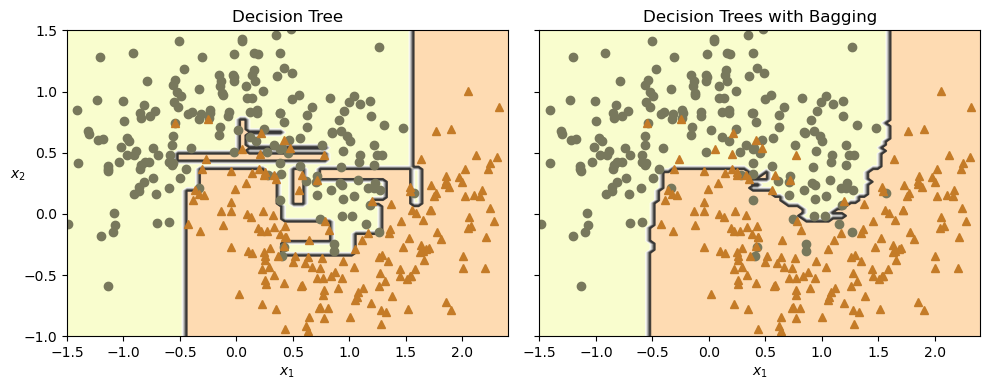

In [18]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

### Out-of-Bag Evaluation

Using Bagging typically results in approximately 63% of the training instances being used, with the other 37% not participating in the training. This 37% portion is called _Out-Of-Bag_ (OOB).

Often, the OOB is used as a validation set and evaluates the accuracy of the model. This can be done from Scikit-Learn using the oob_score_ class. In addition, it is possible to use the decision function for each training instance from `oob_decision_function_`, which can return the class probabilities if there is the `predict_proba()` method.

In [21]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [22]:
bag_clf.oob_decision_function_[:3]  # probas for the first 3 instances

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ]])

In [23]:
from sklearn.metrics import accuracy_score

y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

### Random Patches and Random Subspaces

Feature sampling is something that proves useful when dealing with high-dimensional inputs such as images, and is called the Random Patches Method. Two hyperparameters can control this, `max_features` and `bootstrap_features`.

By keeping all training instances (e.g. `bootstrap` = False and `max_samples` = 1.0) except for the sampled features, it is called the Random Subspaces Method. This results in more diverse predictors, having higher bias and lower variance.

## Random Forests

**Random Forest** operates in a way that uses a `Bagging Classifier` on a `DecisionTreeClassifier`, or, more directly, `RandomForestClassifier`.

In [29]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1,
                       random_state=42)

In [30]:
y_pred_rf = rnd_clf.predict(X_test)
print(y_pred_rf)

[0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 0
 1 1 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 1 0 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1
 0 0 1 1 0 0 0 0 1 1 1 0 0 0]


<div class="alert alert-block alert-info">
<b>Note:</b> The algorithm, instead of using the best feature during splitting, searches for the best feature in a random subset, usually in $\sqrt{n}$. Because of this, a <b>high bias</b> is exchanged for a <b>low variance</b>.
</div>

It is also possible to perform the above task using `Bagging`+ `Decision Tree`

In [33]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16), n_estimators=500, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(max_features='sqrt',
                                                   max_leaf_nodes=16),
                  n_estimators=500, n_jobs=-1, random_state=42)

In [34]:
y_pred_bag = bag_clf.predict(X_test)
y_pred_bag

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int64)

### Extra-Trees

**Extra Trees** (or Extremely Randomized Trees) is a technique that trades _more bias_ for _less variance_, also speeding up the algorithm. It is possible to use both classification and regression using `ExtraTreesClassifier` or `ExtraTreesRegressor`. The algorithm operates in a similar way to _Random Trees_, with the addition of using **random thresholds**.

<div class="alert alert-block alert-info">
<b>Note:</b> It is difficult to say which will perform better between <b>Random Trees</b> and <b>Extra Trees</b>, but the best way is to compare using <i>Cross-Validation</i>. 
</div>

### Feature Importance

The analyzed features are subjected to a **weighted average**, where the weight of each node is equivalent to the number of training samples associated with it. The code below demonstrates the example, where we see that the respective weights are:

44% - petal length, 42% - petal width, 11% - sepal length and 2% - sepal width

In [39]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


This is also possible by analyzing images, demonstrating which pixels are more or less important:

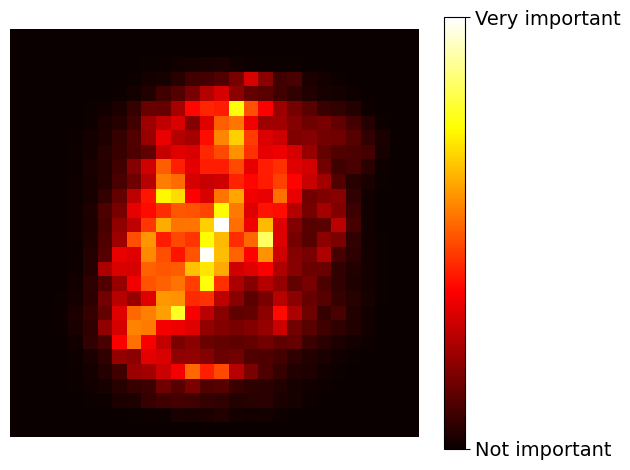

In [41]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False,
                                parser='auto')

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting

**Boosting** is an Ensemble method that uses multiple _weak learners_ to compose a _strong learner_. It operates by making predictors in succession with the intention of the successor being better than each predecessor.

### AdaBoost

**AdaBoost** (or _Adaptive Boosting_) operates by focusing on **hard cases**, that is, paying more attention to training instances that have undergone _Underfitting_.

For example, it starts a classification (first prediction), and then increases the weight of the incorrectly classified instances (second prediction), and does this successively.

<div class="alert alert-block alert-warning">
<b>Alert:</b> This type of training occurs <b>in series, not in parallel</b>. Therefore, unlike other Ensemble forms, <b>it does not scale well</b>.
</div>

Below, we will explain how the algorithm works step by step, this section is optional.

A brief summary of how the algorithm works is shown below:

1. First prediction
2. First weight estimate ($w^{(i)}$)
3. Weighted Error Rate
4. Predictor Weight
5. Weight Update Rule
6. AdaBoost Prediction

**1. First Prediction**

In the first prediction, all weights are set to the same value, $\frac{1}{m}$, where m is the number of instances.

**2. First weight estimate ($w^{(i)}$)**

After the first predictor is trained, an error rate is calculated with the equation, where $\hat{y}_{j}^{(i)}$  is the prediction for the $i^{th}$ term:

$$
r_{j} = \sum_{i=1 \: \: and \: \: \hat{y}_{j}^{(i)} \neq y_{j}^{(i)}}^{m} w^{(i)}
$$

An example can be seen in the code below:

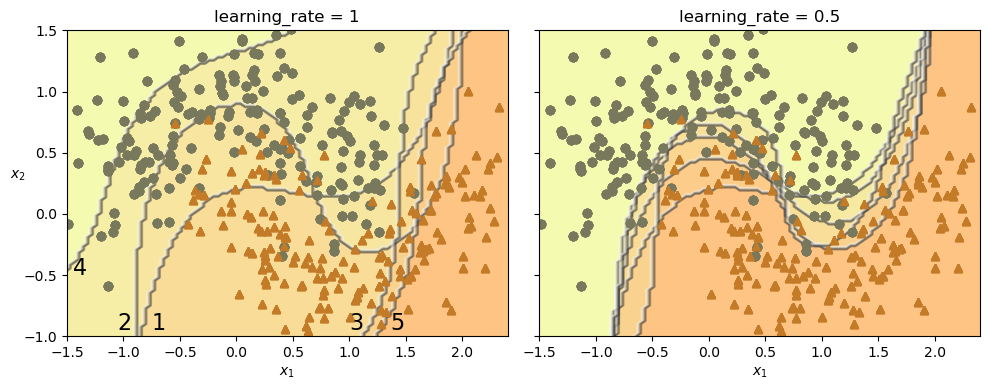

In [46]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### Gradient Boosting

       
### Histogram-Based Gradient Boosting

## Stackin